<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(11_29).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第8回）**##
今回から数回にわたり、時系列解析を学んでいこう。
自己回帰型モデル、状態推定モデルのいくつか有名なモデルを解説する。

###**時系列データ**###
ある時間間隔で測定したデータで、毎時気温、風速から株価指数まで、多種多様にある。また、似たデータ系列として、web広告のクリックのようなイベント記録があるが、これは点過程データと呼び、前者の時系列データとは区別される。

###**構成要素**###
時系列データは、時系列データを構成する３つの要素に分けて特徴づけられる


1.   傾向変動：時間とともに増加（減少）する変動であるが、増加（減少）の傾向を持続するのが特徴
2.   季節変動：１年を周期として規則的に繰り返す変動（海水温やアイスクリームの週次売上など）。１年周期でなくても、周期的なものはここにカテゴライズ。
3.   不規則変動：上記以外の変動成分






###**成分分解モデル(Decomposition model)**###
時系列データを構成要素の合成と考えたとき、その合成には２通りある。


1.   加法モデル(Additive): $x_t =$ Trend + Seasonal + Random
2.   乗法モデル(Multiplicative): $x_t=$ Trend * Seasonal * Random

下記のコードを動かして、成分の合成の仕方の違いで、時系列データの"見た目"にどのような違いが生じるのか実感しよう。

####**加法モデルと乗法モデルのどちらを選ぶか？**####
加法モデルは、$x_t$の値によらず、一定した周期変動の大きさが見られるときに有用。
乗法モデルは、$x_t$の絶対値が大きいときは、大きな変動幅、小さいときは小さな変動幅が見られるときに使える。



/tmp/ipython-input-527848089.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_random[i] = np.random.normal(0,1,1)


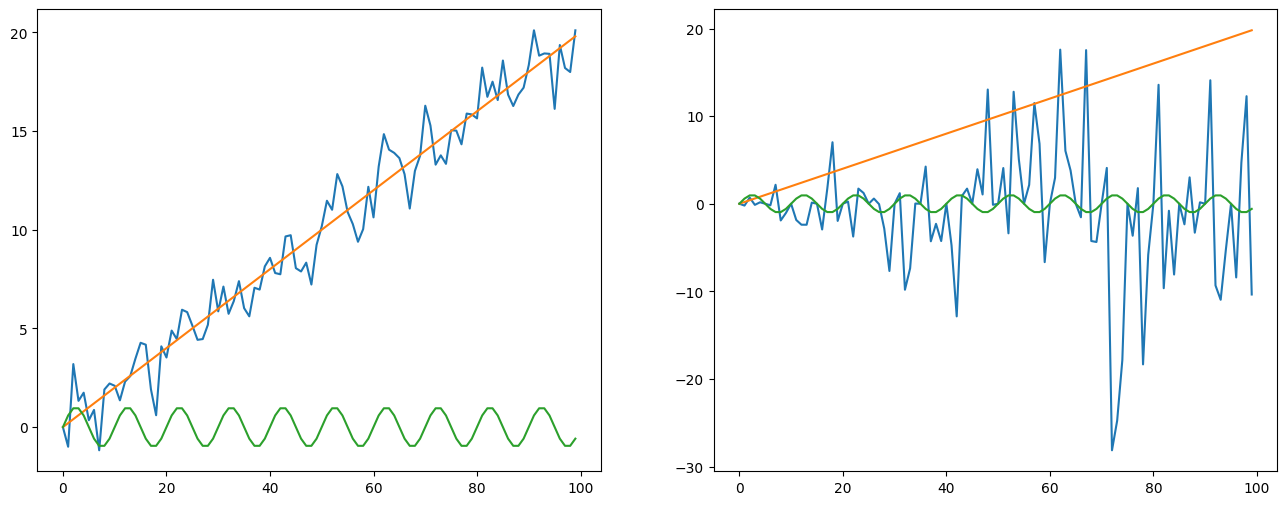

In [100]:
##
## ３つの成分の合成の仕方を変えると
## どのような時系列データになるのか実感しよう
##
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


def f(x):
  return 0.2*x

def season(x):
  return 1.0*np.sin(0.2*np.pi*x)

x=np.zeros(100)
x_trend=np.zeros(100)
x_season=np.zeros(100)
x_random=np.zeros(100)
for i in range (100):
  x_trend[i] = f(i)
  x_season[i] = season(i)
  x_random[i] = np.random.normal(0,1,1)

x = x_trend + x_season + x_random
z = x_trend*x_season*x_random

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x)
ax1.plot(x_trend)
ax1.plot(x_season)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(z)
ax2.plot(x_trend)
ax2.plot(x_season)

###**平滑化**###
平滑化は、時系列データから不規則変動を除去して、傾向変動や季節変動を取り出すことを目的に行われる。平滑化手法としては、時系列の時間局所（あるタイムウインドウ）における平均値、あるいは、中央値を計算する方法があり、前者を移動平均、後者を移動中央値という。本講義では移動平均を扱う。

$$
T_n = \frac{1}{2k+1}\sum_{i=-k}^k x_{n+j}
$$
もとの時系列が直線とホワイトノイズの和で表されるとき、
$w_n \sim N(0,\sigma^2)$として、
$$
x_n = t_n+w_n\\
t_n = a + bn
$$
$$
T_n = t_n + \frac{1}{2k+1}\sum_{j=-k}^kw_{n+j}
$$
$$
E\left[\sum_{j=-k}^kw_{n+j}\right] = 0
$$

$$
E\left[\left(\sum_{j=-k}^kw_{n+j}\right)^2\right] = (2k+1)\sigma^2
$$
$$
Var\left[\frac{1}{2k+1}\sum_{j=-k}^kw_{n+j}\right]=\frac{\sigma^2}{2k+1}
$$
よって、移動平均の期待値$T_n=t_n$、分散は元の時系列$x_n$の$1/(2k+1)$倍に減少する。

下記のコードを実行し、移動平均のタイムウインドウを様々に試すことで、時系列データのもつ傾向がどのように見えるのかを実感しよう。



In [101]:
## 移動平均の例
## 講義用にデータをダウンロードしてください
!wget https://www.dropbox.com/s/pld64byqj7nevhu/AirPassengers.csv

## これは航空機乗客データです
## Rで有名なデータ (https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html)
##

--2025-10-27 00:38:27--  https://www.dropbox.com/s/pld64byqj7nevhu/AirPassengers.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/qnodwyidfqpn97xep9n4c/AirPassengers.csv?rlkey=99aq4qdpx9uvf0ymqnh34fe32 [following]
--2025-10-27 00:38:27--  https://www.dropbox.com/scl/fi/qnodwyidfqpn97xep9n4c/AirPassengers.csv?rlkey=99aq4qdpx9uvf0ymqnh34fe32
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6b10f77d68edd55a5f54234ad2.dl-jp.dropboxusercontent.com/cd/0/inline/Cz-ulAMvNC9QSriHKyb0s2txYo1cJt2D6mU1ka7qOrP3cNaAAYfF7zCgUu_f510ZuABXbaqtCVizKnf60PAJ958GsOUiNmHItYy1cod86xklwdoFhUGrHWW4BhQJanEn_hJZCqxh2wSWHDyG78nxhJWx/file# [following]
--2025-10-27 00:38:28--  https://uc6b10f77d68edd55a5f54234ad2.dl-jp.dropboxusercont

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


<Axes: >

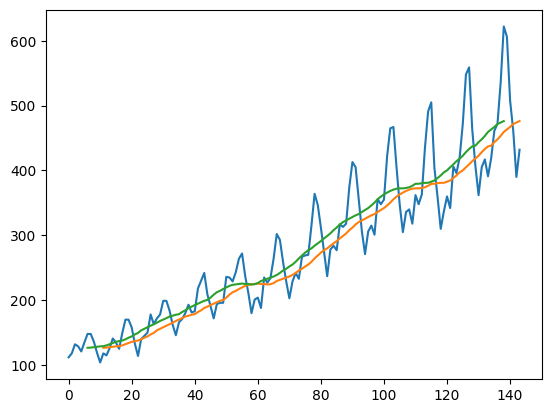

In [102]:
import pandas as pd

timeWindow=12 #12months

df = pd.read_csv("AirPassengers.csv")
print(df.head())
passengers = df['#Passengers']
passengers.plot()
## 12か月移動平均
## 後方移動平均(対象時点とそれより過去のデータを使って平均)
passengers.rolling(window=timeWindow,center=False).mean().plot()
## 中央移動平均（対象時点が中心となるよう、過去・未来のデータを使って平均）
passengers.rolling(window=timeWindow,center=True).mean().plot()


###**共分散関数と自己相関関数**###
データが得られたときに、一番最初に行うのが、基本的な統計量を用いた要約である。

自己共分散関数は、時系列の過去の変動との関連の強さを表現、相互共分散関数は他の時系列の変動との関連の強さを表現する。１変量（１次元）時系列の場合は、自己相関、自己共分散が基本的な統計量である。多変量の場合は、平均ベクトル、相互相関、相互共分散が基本となる。

時系列$y_n$と時間$k$だけシフトした時系列$y_{n-k}$との共分散
$$
Cov(y_n, y_{n-k}) = E[(y_n-\mu_n)(y_{n-k}-\mu_{n-k})]
$$
を時系列$y_n$の自己共分散という。$k$を**ラグ**という。$k=0$のとき、分散関数$Var(y_n)$となる。

平均、分散、共分散が時間のシフトに対して、不変であるとき、**弱定常**という。
$$
E[y_n] = E[y_{n-l}]\\
Var(y_n) = Var(y_{n-l})\\
Cov(y_n,y_m)=Cov(y_{n-l},y_{m-l})
$$
'弱'があれば、'強'は何かということであるが、時系列の確率分布が時間シフトに対して不変のときに、その時系列を強定常という。
すなわち、時刻$i_1 < i_2 < \cdots < i_k$について、時系列$y_{i_1}, y_{i_2},\cdots,y_{i_k}$の同時確率密度関数$f(y_{i_1},\cdots,y_{i_k})$について、
$$
f(y_{i_1},\cdots,y_{i_k}) = f(y_{i_1-l},\cdots,y_{i_k-l})
$$
が成り立つことである。
もし、同時確率密度関数がガウス型（ガウス型時系列という）であれば、１次モーメント、２次モーメントまでで正規分布の形が決まるので、弱定常性と強定常性は同じになる。

####**定常時系列**####
定常性を仮定すると、平均値関数$\mu_n$は時刻$n$に依存せず
$$
\mu = E[y_n]
$$
また、共分散は時間差$k$のみに依存するので
$$
C_k = Cov(y_n,y_{n-k})=E[(y_n-\mu)(y_{n-k}-\mu)]
$$
と表される。これを定常時系列の自己共分散関数という。

$y_n$と$y_{n-k}$の相関係数
$$
R_k = \frac{Cov(y_n,y_{n-k})}{\sqrt{Var(y_n)Var(y_{n-k})}}
$$
をラグ$k$の関数とみなしたものを、自己相関関数という。定常時系列では、
$Var(y_n)=Var(y_{n-k})=C_0$より、
$$
R_k = C_k/C_0
$$
となる。

多変量のときには、対応する関数は以下の通り。多変量時系列$y_n$を
$$
y_n = (y_n(1),\cdots,y_n(l))^T
$$
とし、
$$
C_k(i,j) = Cov(y_n(i),y_{n-k}(j))=E[(y_n(i)-\mu(i))(y_{n-k}(j)-\mu(j))^T]
$$
$C_k$は$l\times l$行列となり、ラグ$k$の共分散関数という。
対角成分$C_k(i,i)$は$i$番目の時系列$y_n(i)$の自己共分散関数となっている。
$y_n(i)$と$y_{n-k}(j)$の相関係数を
$$
R_k(i,j) = \frac{C_k(i,j)}{\sqrt{C_0(i,i)C_0(j,j)}}
$$
と表し、$l \times l$行列$R_k$を相互相関関数という。

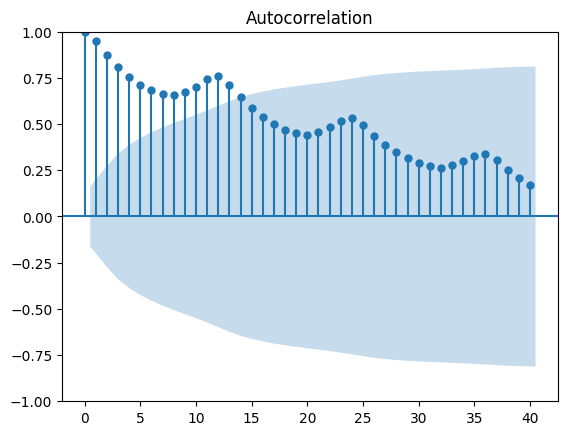

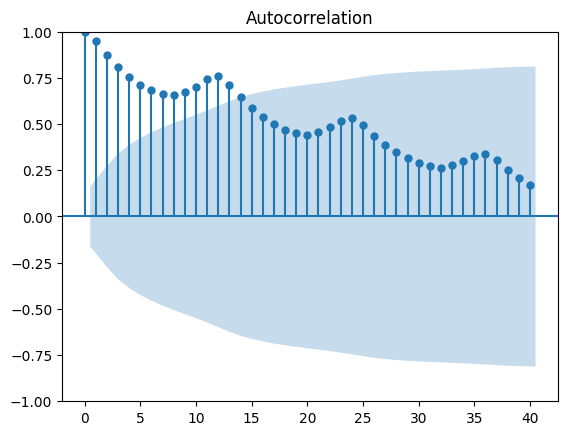

In [103]:
import pandas as pd
import statsmodels.api as sm

timeWindow=12 #12months

df = pd.read_csv("AirPassengers.csv")
passengers = df['#Passengers']

#自己相関
p_acf = sm.tsa.stattools.acf(passengers)

##自己相関係数のプロットをコレログラムという
##帯の外にある点は有意水準5％で無相関という帰無仮説を棄却する
sm.graphics.tsa.plot_acf(passengers,lags=40)

##**自己回帰型モデル**##
###**ARMAモデル**###
時系列$y_n$を過去の観測値$y_{n-i}$の線形和とホワイトノイズの現在および過去の値の線形和で表したモデルを**自己回帰移動平均モデル(Auto Regration Moving Average model**という。(頭文字をとって、ARMAモデル)

$$
y_n = \sum_{i=1}^m a_iy_{n-i} + v_n - \sum_{i=1}^lb_iv_{n-i}\\
v_n\sim N(0,\sigma^2)
$$
ここで、$m, a_i$をそれぞれ自己回帰の次数、自己回帰係数という。また、$l,b_i$を移動平均の次数、移動平均係数という。2つの次数をまとめて、$(m,l)$次のARMAモデルという。
ARMAモデルに従う時系列は、ARMA過程あるいはARMA$(m,l)$過程と呼ばれる。

$l=0$と仮定すると、$m$次の自己回帰モデル(ARモデル)となる。
$$
y_n = \sum_{i=1}^m a_iy_{n-i} + v_n
$$
$m=0$と仮定すると、$l$次の移動平均モデル(MAモデル)となる。
$$
y_n = v_n - \sum_{i=1}^lb_iv_{n-i}
$$

###**インパルス応答関数と自己共分散関数**###
時間シフトオペレーター$B$を
$$
By_n = y_{n-1}
$$
と定義する。
ARMAモデルは
$$
(1-\sum_{i=1}^ma_iB^i)y_n = (1-\sum_{i=1}^lb_iB^i)v_n
$$
と表される。
いま、$a(B):=1-\sum_{i=1}^ma_iB^i$、$b(B):=1-\sum_{i=1}^lb_iB^i$と定義し
$$
a(B)y_n = b(B)v_n
$$
また、
$$
a(B)^{-1}b(B)=\sum_{i=0}^\infty g_iB^i
$$
と書くことにすると
$$
y_n = g(B)v_n = \sum_{i=0}^\infty g_i v_{n-i}
$$
これはARMA過程を無限次MAモデルで表現できることを示している。
$g(B)$をARMAモデルのインパルス応答関数という。
$$
g_0=1\\
g_i=\sum_{j=1}^ia_jg_{i-j}-b_i (i=1,2,\cdots)
$$
ただし、モデル次数より大きい添え字の係数値はゼロとする。
$a_j=0 ( j>m), b_i=0 (i > l)$

ARMAモデル式の両辺に$y_{n-k}$をかけて期待値を取る
$$
E[y_n y_{n-k}]= \sum_{i=1}^m a_iE[y_{n-i}y_{n-k}] + E[v_n y_{n-k}] - \sum_{i=1}^lb_iE[v_{n-i}y_{n-k}]
$$
ここで、右辺第2項、第3項を拙速に期待値ゼロにしていはいけない。インパルス応答関数を用いると

$$
E[v_{n-i} y_{n-k}]=\sum_{j=0}^\infty g_j E[v_{n-i} v_{n-k-j}]\\
$$
$$
=
\begin{array}
 00 & (i > k)\\
\sigma^2 g_{i-k} & (i \leq k)
\end{array}
$$
となる。
よって、自己共分散関数は
$$
C_0 = \sum_{i=1}^ma_iC_{-i}+\sigma^2(1-\sum_{i=1}^lb_ig_i)\\
C_k  = \sum_{i=1}^m a_iC_{k-i}-\sigma^2\sum_{i=1}^lb_ig_{i-k}, (k=1,2,\cdots)
$$

**Yule-Waker方程式**

特に、$l=0$としたときにはARモデルの場合の関係式として、以下のYule-Waker（ユール・ウォーカー）方程式が得られる。
$$
C_0 = \sum_{i=1}^ma_iC_{-i}+\sigma^2\\
C_k  = \sum_{i=1}^m a_iC_{k-i}, (k=1,2,\cdots)
$$
時系列から標本自己共分散関数$\hat C_k$を計算し、Yule-Waker方程式を解くと、ARモデルにおける自己回帰係数の推定値$\hat a_i$が得られる。
また、$C_0$の式より、分散の推定値$\hat\sigma^2$も得られる。これらを、Yule-Walker推定値という。これでAICの計算を行うことが出来るので、ARモデルの次数$m$を決めることが出来る。

##**解析実習 part1**##
太陽黒点の数の時系列解析をARMAモデルで行ってみよう。
まず、Yearly mean total sunspot number (メニューTotal sunspot number --> Yearly mean total sunspot numberを選択)のデータを[ダウンロード](https://sidc.be/silso/datafiles)し、Colabのフォルダにアップロードしよう。


Pythonの[statsmodels](https://www.statsmodels.org/stable/index.html)を利用し、まず、(3,0)次ARMAモデルによる解析を行う。モデルの次数選択については、あまり宜しくない例となっている。

その次に、適切な次数選択をpart2で体験しよう。情報量基準を用いたモデル選択により、どのように改善されるのかを、残差の相関関数に注目しながら確かめよう。

In [104]:
## Yearly mean total sunspot number
## ダウンロード：https://sidc.be/silso/datafiles
## データの並びの説明: https://sidc.be/silso/infosnytot
!wget https://sidc.be/SILSO/INFO/snytotcsv.php -O sunspot_data.csv
col_names = ['year', 'sunActivity', 'sd', 'numObs', 'defMarker']
df_sunspot = pd.read_csv(
    "sunspot_data.csv",
    sep=';',
    header=None,
    names=col_names
)

--2025-10-27 00:38:29--  https://sidc.be/SILSO/INFO/snytotcsv.php
Resolving sidc.be (sidc.be)... 193.190.230.16
Connecting to sidc.be (sidc.be)|193.190.230.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘sunspot_data.csv’

sunspot_data.csv        [ <=>                ]   9.20K  --.-KB/s    in 0s      

2025-10-27 00:38:30 (107 MB/s) - ‘sunspot_data.csv’ saved [9425]



<Axes: >

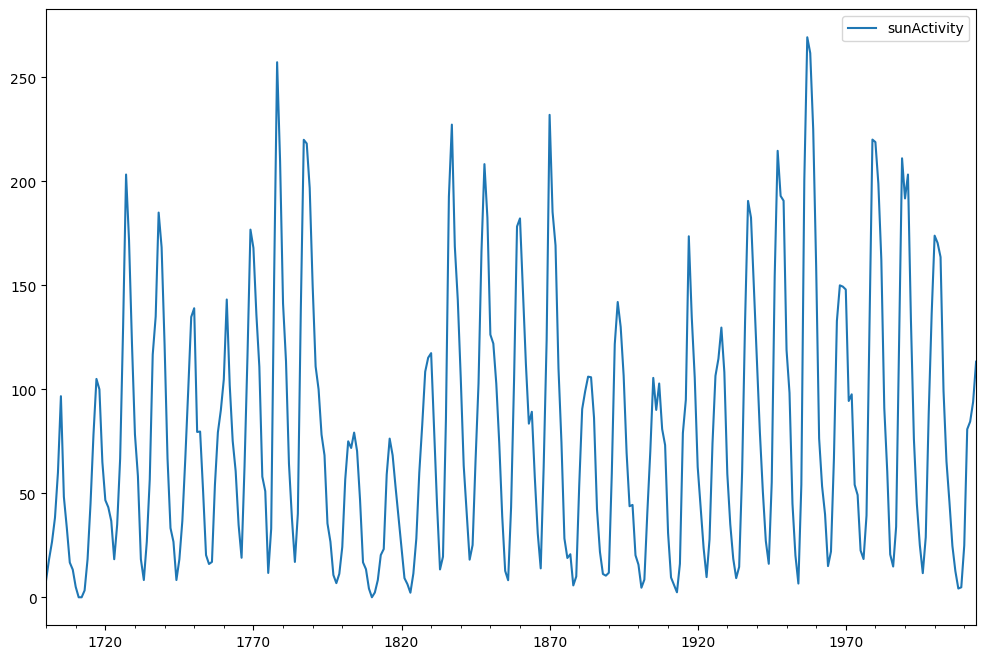

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

## ARIMAモデルを読み込む
## ARMA(p,q) = ARIMA(p,0,q)
## ARIMA(p,d,q)の次数dは、d階差分を表す。
## 差分を取ると定常過程になるものを和分過程という
## トレンドがある場合に有効
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

dtaFull=df_sunspot[['year','sunActivity']]

## 2025.10月時点でのデータに対するインデックスの割り付けをしているので、最終行が2024年以降であったら
## pd.Index(sm.tsa.datetools.dates_from_range("1700", "2024"))の2021を最終行の西暦年にすること。
dtaFull.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2024"))
dtaFull.index.freq = dtaFull.index.inferred_freq
del dtaFull["year"]

##直近10年分を除いたデータをモデルフィットに使用し、直近10年を予測する
dta = dtaFull[:len(dtaFull)-10]
dta.plot(figsize=(12, 8))


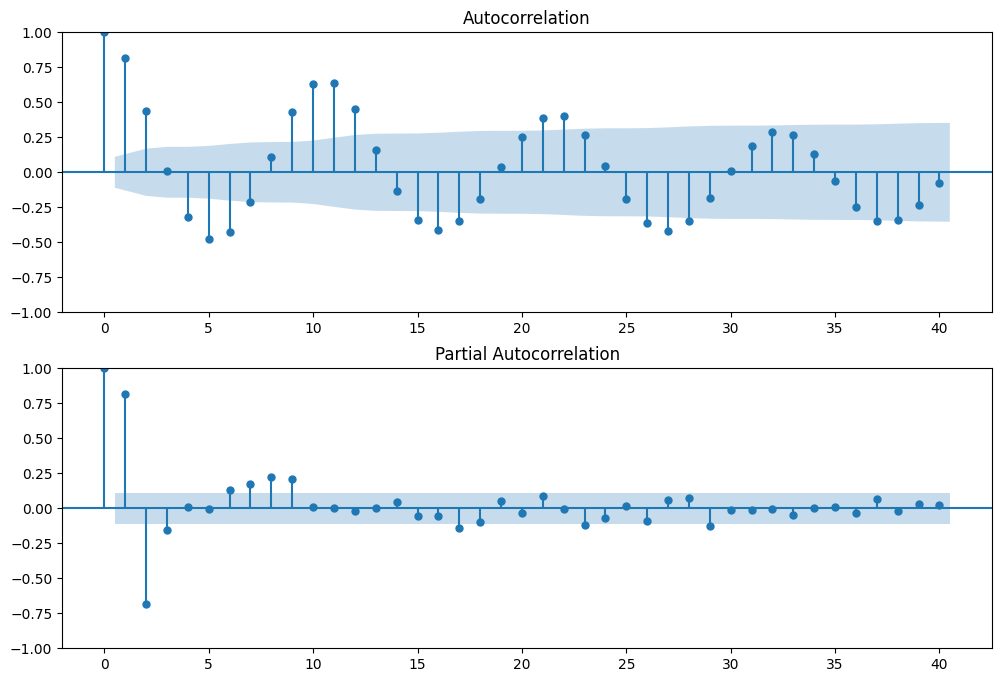

In [106]:
## 自己相関からおよそ11年周期だと分かる
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [107]:
arma_mod20 = ARIMA(dta, order=(2, 0, 0)).fit()
print(arma_mod20.params)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

const      79.538206
ar.L1       1.383054
ar.L2      -0.692120
sigma2    661.536443
dtype: float64
2950.1444069500108 2965.1546975053134 2956.1415843115847


In [108]:
arma_mod30 = ARIMA(dta, order=(3, 0, 0)).fit()
print(arma_mod30.params)
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

const      79.543450
ar.L1       1.282917
ar.L2      -0.493162
ar.L3      -0.143393
sigma2    647.763291
dtype: float64
2945.587897950363 2964.3507611444916 2953.0843696523307


In [109]:
## The Durbin-Watson statistic
##
sm.stats.durbin_watson(arma_mod30.resid.values)

np.float64(1.9662364467539102)

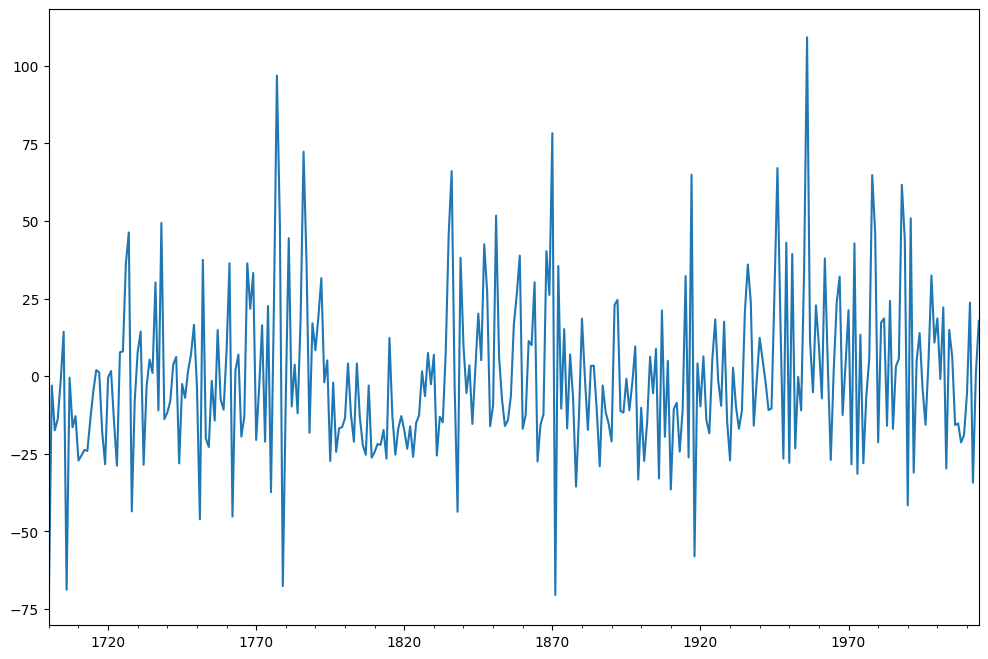

In [110]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax)

In [111]:
##残差が正規分布からズレていないかを確認
resid = arma_mod30.resid
stats.normaltest(resid)

NormaltestResult(statistic=np.float64(36.72858453826968), pvalue=np.float64(1.0580086136166044e-08))

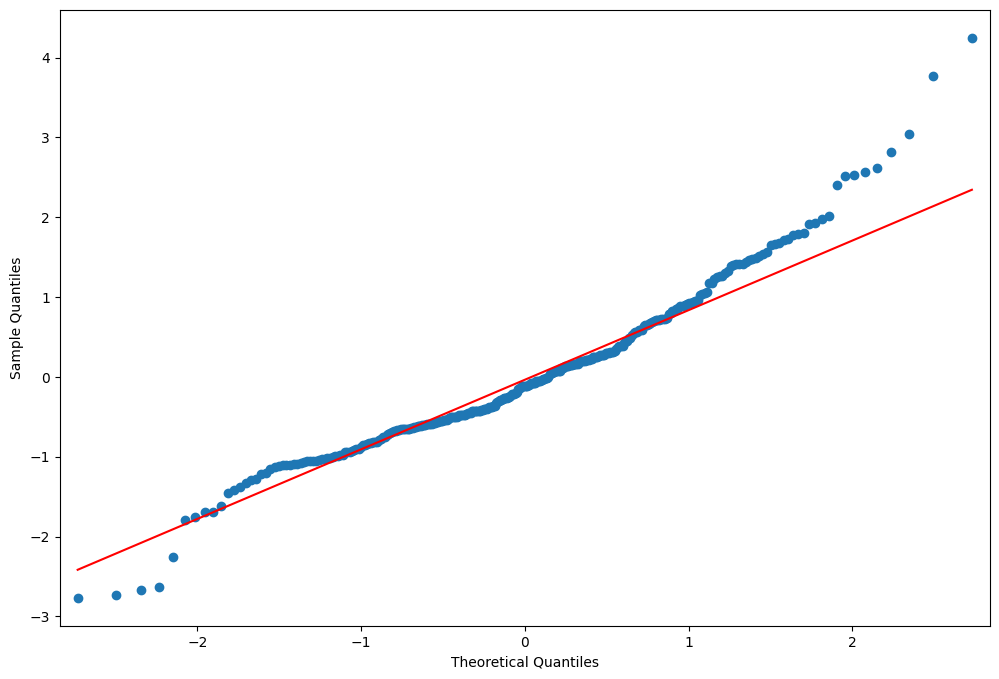

In [112]:
##Q-Qプロットでも確認
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

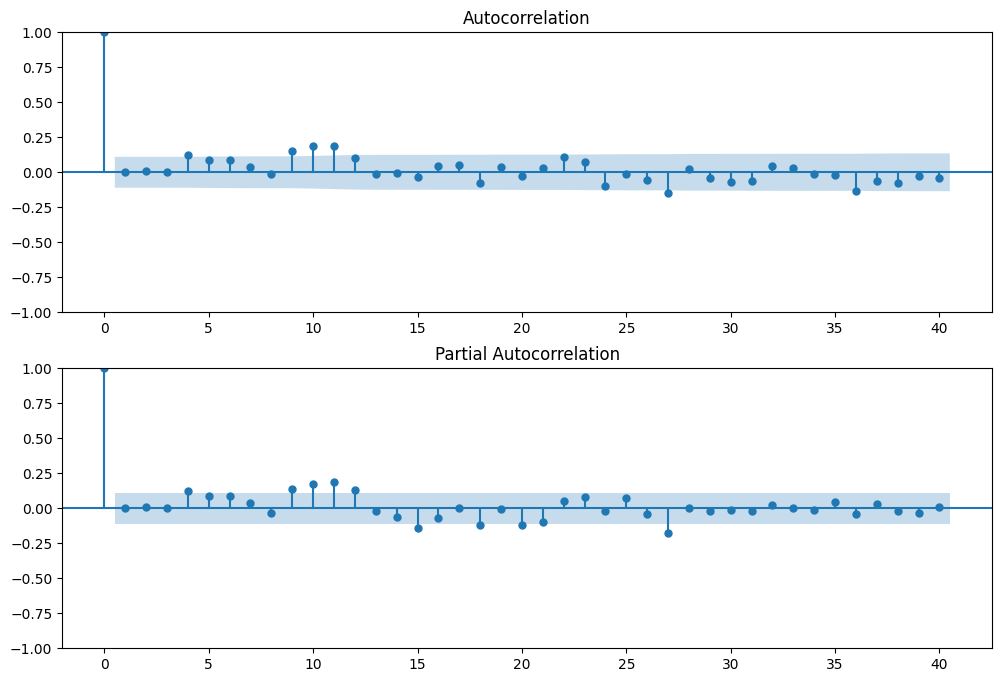

In [113]:
##
## 残差の自己相関、偏自己相関がともに残っているので、時系列を捉えきれていないモデルであることを示唆している
## （残差はホワイトノイズに従うべき）
##
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [114]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
##
## AutoCorrelation, Q-value, P-value
##
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

           AC          Q  Prob(>Q)
lag                               
1    0.003945   0.004949  0.943916
2    0.011456   0.046816  0.976864
3    0.000682   0.046965  0.997331
4    0.126038   5.147484  0.272497
5    0.089330   7.717889  0.172484
6    0.084995  10.052415  0.122462
7    0.039990  10.570883  0.158463
8   -0.014735  10.641501  0.222851
9    0.154361  18.416947  0.030633
10   0.188722  30.077443  0.000832
11   0.188660  41.768598  0.000018
12   0.101282  45.149188  0.000010
13  -0.009352  45.178107  0.000020
14  -0.002836  45.180776  0.000038
15  -0.036122  45.615081  0.000061
16   0.046664  46.342285  0.000086
17   0.053253  47.292541  0.000110
18  -0.075077  49.187605  0.000100
19   0.035421  49.610852  0.000150
20  -0.025125  49.824526  0.000235
21   0.033488  50.205424  0.000342
22   0.109257  54.273573  0.000151
23   0.076490  56.274360  0.000130
24  -0.100783  59.759765  0.000069


In [115]:
predict_sunspots = arma_mod30.predict("2010", "2022", dynamic=True)
print(predict_sunspots)

2010-12-31     30.409590
2011-12-31     64.173176
2012-12-31     94.773341
2013-12-31    113.707645
2014-12-31    118.066469
2015-12-31    109.932935
2016-12-31     94.633624
2017-12-31     78.392002
2018-12-31     66.266683
2019-12-31     60.914479
2020-12-31     62.356734
2021-12-31     68.585223
2022-12-31     76.632063
Freq: YE-DEC, Name: predicted_mean, dtype: float64


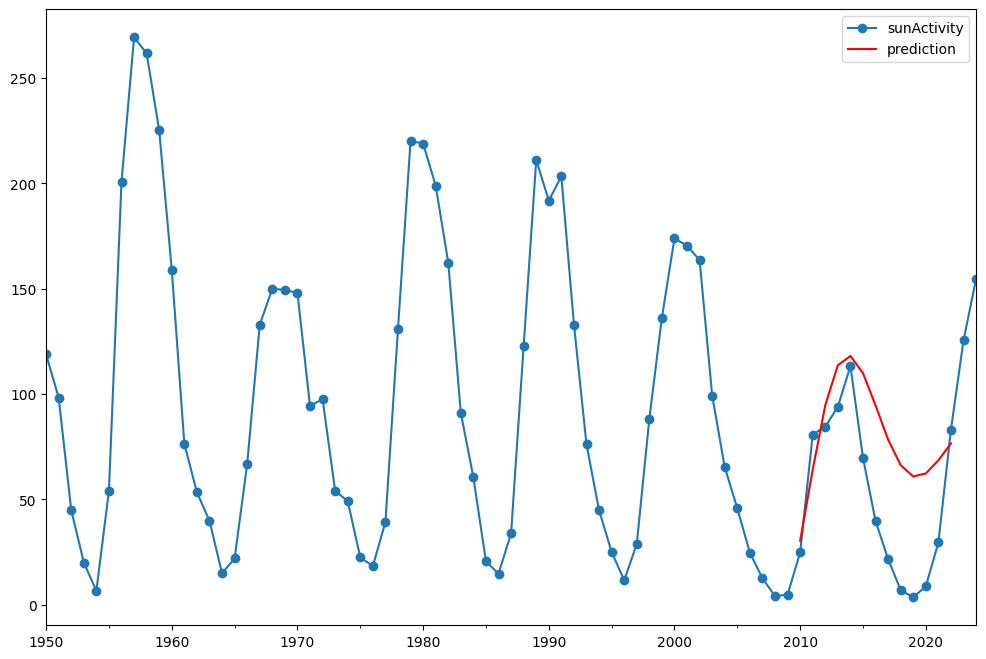

In [116]:
fig, ax = plt.subplots(figsize=(12, 8))
dtaFull.loc['1950':].plot(ax=ax,marker="o")
predict_sunspots.plot(ax=ax, style='r', label="prediction")
plt.legend()

##**解析実習 part2**##
次数を決め打ちせず、次数の組み合わせの中で、AIC、BICが最小となるモデル選択を行う

In [117]:
##
## AIC, BIC によるモデル選択
##
from statsmodels.tsa import stattools
res = stattools.arma_order_select_ic(
    dta,
    max_ar=8,
    max_ma=10,
    ic=["aic", "bic"],
)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

In [118]:
print("AIC_Minimum model:ARMA",res.aic_min_order, "BIC_Minimum model:ARMA",res.bic_min_order)

AIC_Minimum model:ARMA (np.int64(8), np.int64(6)) BIC_Minimum model:ARMA (np.int64(5), np.int64(4))


####**AICをもとにモデル選択**####

In [119]:
print(res.aic)

            0            1            2            3            4   \
0  3498.581497  3214.549497  3056.745359  3006.983243  2983.287694   
1  3154.284212  3044.712442  2995.792581  2987.773984  3010.743550   
2  2950.144407  2946.097976  2947.592734  2949.461916  2932.822071   
3  2945.587898  2947.451703  2949.115166  2951.401024  2911.205905   
4  2947.529426  2949.187580  2951.108680  2945.375955  2911.620446   
5  2949.386761  2950.794103  2945.076825  2948.688465  2901.827265   
6  2945.374855  2920.282715  2908.969109  2940.850327  2930.361816   
7  2934.374812  2914.841980  2913.036529  2910.166179  2912.206479   
8  2921.664075  2912.673129  2913.109787  2924.261470  2914.211558   

            5            6            7            8            9   \
0  2979.385825  2980.971927  2980.975949  2973.972240  2973.424526   
1  2985.857476  2976.736271  2977.380598  2972.839295  2963.293612   
2  2930.307468  2926.617043  2926.694322  2927.831437  2914.209555   
3  2909.644627  291

In [120]:
arma_mod86 = ARIMA(dta, order=(8, 0, 6)).fit(
    method_kwargs={'maxiter': 1000} #Convergence errorが出るときは、イタレーション回数の最大値を増やす
)
print(arma_mod86.params)
print(arma_mod86.aic,arma_mod86.bic)

const      79.349081
ar.L1       2.304807
ar.L2      -2.149857
ar.L3       0.754678
ar.L4      -0.402190
ar.L5       1.483576
ar.L6      -2.065470
ar.L7       1.237569
ar.L8      -0.229483
ma.L1      -1.142830
ma.L2       0.372248
ma.L3       0.151105
ma.L4       0.572391
ma.L5      -1.241401
ma.L6       0.720502
sigma2    508.272050
dtype: float64
2897.210706270424 2957.251868491634


In [121]:
sm.stats.durbin_watson(arma_mod86.resid.values)

np.float64(1.9854479962535743)

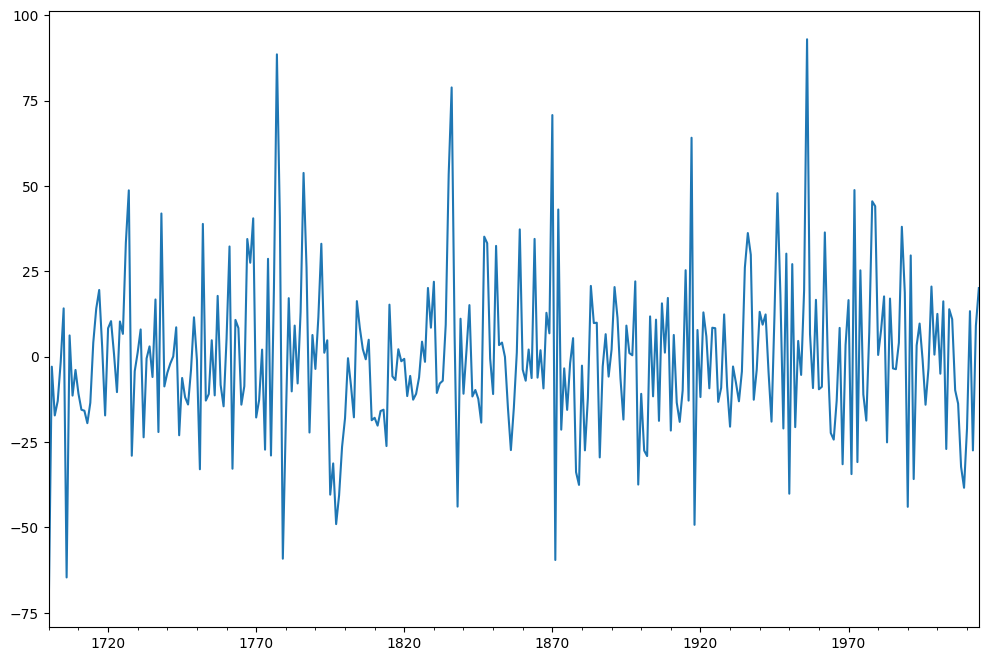

In [122]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod86.resid.plot(ax=ax)

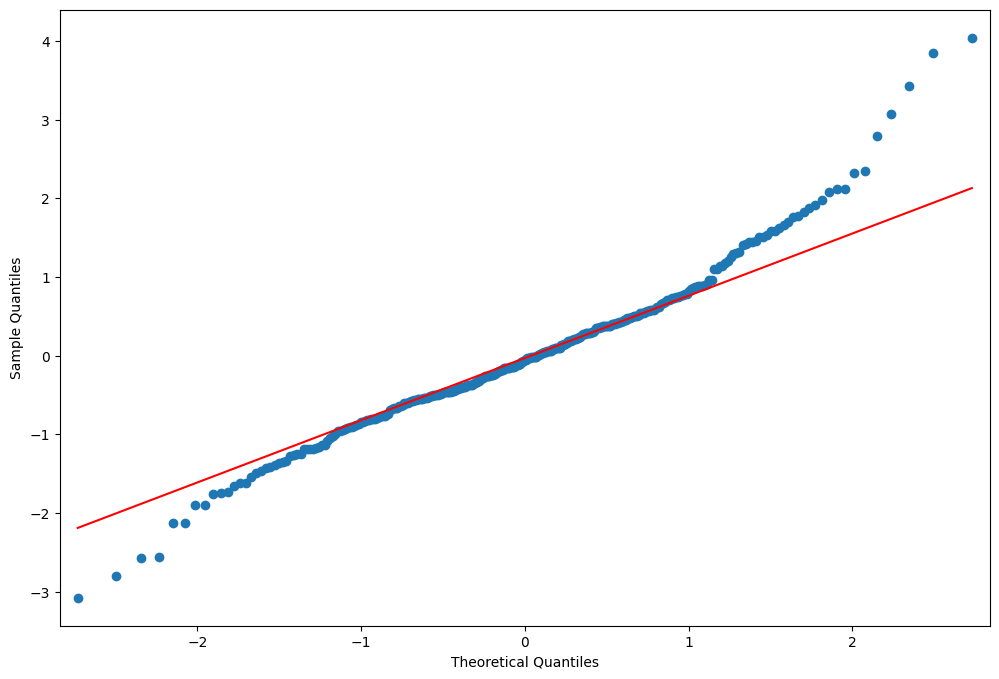

In [123]:
resid = arma_mod86.resid
stats.normaltest(resid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

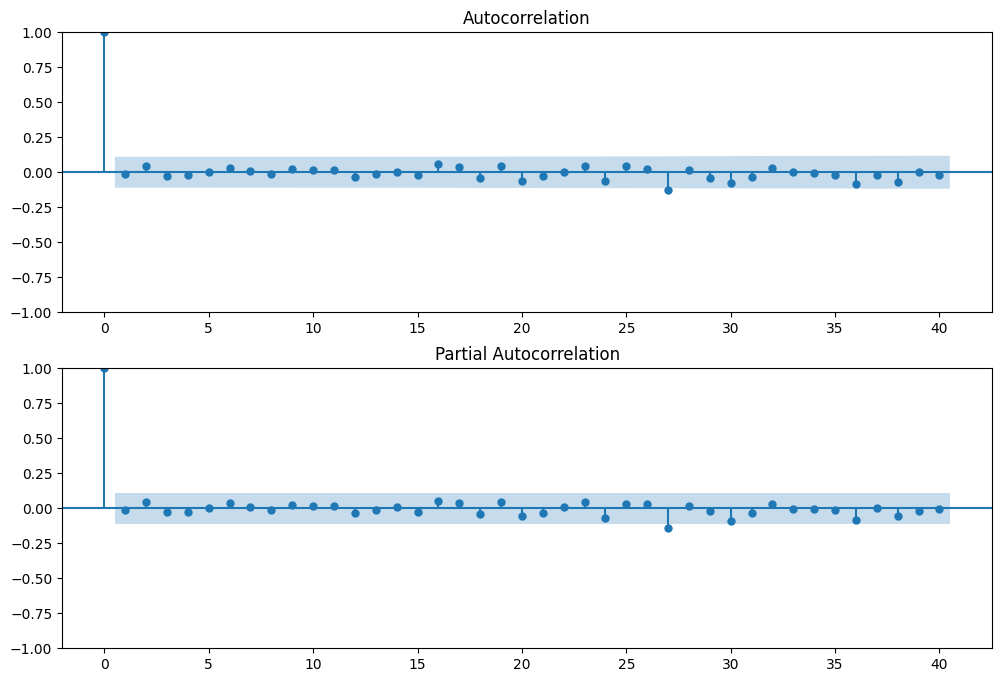

In [124]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

残差の統計検定

注目する列: Prob(>Q) (P値)
* 帰無仮説 ($H_0$): 「残差には自己相関がない」（＝ホワイトノイズである）
* 対立仮説 ($H_1$): 「残差には自己相関がある」（＝モデルが情報を捉えきれていない）

もし、Prob(>Q) < 0.05 (P値が低い)ならば自己相関が残っている可能性が高い。

In [125]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
##
## AutoCorrelation, Q-value, P-value
##
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

           AC         Q  Prob(>Q)
lag                              
1   -0.009040  0.025986  0.871935
2    0.047355  0.741387  0.690255
3   -0.029838  1.026334  0.794880
4   -0.020972  1.167547  0.883412
5   -0.000346  1.167586  0.947949
6    0.033670  1.533932  0.957209
7    0.011767  1.578822  0.979455
8   -0.008909  1.604639  0.990831
9    0.023123  1.779110  0.994499
10   0.013882  1.842201  0.997413
11   0.017437  1.942074  0.998689
12  -0.032277  2.285398  0.998826
13  -0.011831  2.331679  0.999467
14   0.002245  2.333350  0.999788
15  -0.022705  2.504944  0.999871
16   0.059006  3.667724  0.999367
17   0.037351  4.135188  0.999353
18  -0.038898  4.643895  0.999315
19   0.043665  5.287079  0.999148
20  -0.062066  6.591001  0.997827
21  -0.027867  6.854765  0.998410
22   0.003210  6.858278  0.999133
23   0.044729  7.542443  0.998986
24  -0.065528  9.015897  0.997562


In [126]:
predict_sunspots = arma_mod86.predict("2011", "2024", dynamic=True)
predict_sunspots_onestep = arma_mod86.predict("1950", "2024", dynamic=False)
print(predict_sunspots)

2011-12-31     67.479614
2012-12-31     96.516172
2013-12-31    104.806527
2014-12-31    100.926911
2015-12-31     86.031401
2016-12-31     65.399033
2017-12-31     38.584368
2018-12-31     11.865292
2019-12-31      1.635013
2020-12-31     13.071217
2021-12-31     45.496151
2022-12-31     83.958757
2023-12-31    109.273194
2024-12-31    116.359625
Freq: YE-DEC, Name: predicted_mean, dtype: float64


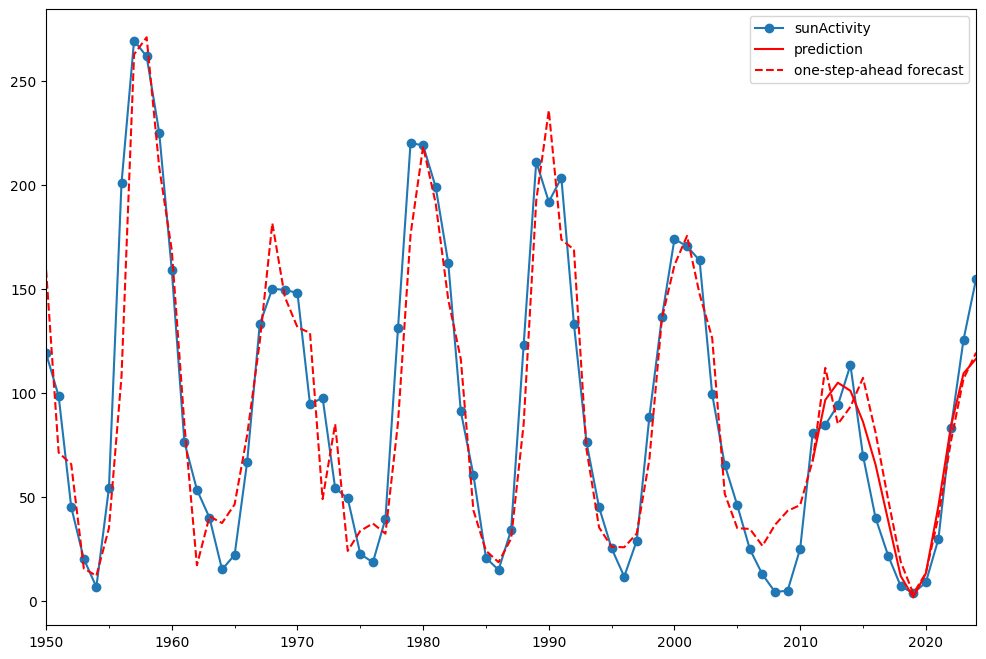

In [127]:
fig, ax = plt.subplots(figsize=(12, 8))
dtaFull.loc['1950':].plot(ax=ax,marker="o")
predict_sunspots.plot(ax=ax, style='r', label="prediction")
predict_sunspots_onestep.plot(ax=ax, style='r--', label="one-step-ahead forecast")
plt.legend()

####**BICをもとにモデル選択**####

In [128]:
print(res.bic)

            0            1            2            3            4   \
0  3506.086642  3225.807215  3071.755649  3025.746106  3005.803130   
1  3165.541930  3059.722733  3014.555444  3010.289420  3037.011559   
2  2965.154698  2964.860839  2970.108170  2975.729925  2962.842652   
3  2964.350761  2969.967139  2975.383175  2981.421605  2944.979059   
4  2970.044862  2975.455588  2981.129261  2979.149109  2949.146173   
5  2975.654770  2980.814684  2978.849979  2986.214192  2943.105564   
6  2975.395436  2954.055869  2946.494835  2982.128626  2975.392688   
7  2968.147965  2952.367707  2954.314828  2955.197051  2960.989923   
8  2959.189802  2953.951428  2958.140659  2973.044914  2966.747575   

            5            6            7            8            9   \
0  3005.653833  3010.992508  3014.749103  3011.497966  3014.702825   
1  3015.878057  3010.509425  3014.906325  3014.117594  3008.324484   
2  2964.080621  2964.142770  2967.972621  2972.862309  2962.992999   
3  2947.170353  295

In [129]:
arma_mod54 = ARIMA(dta, order=(5, 0, 4)).fit(
    method_kwargs={'maxiter': 1000} #Convergence errorが出るときは、イタレーション回数の最大値を増やす
)
print(arma_mod54.params)
print(arma_mod54.aic, arma_mod54.bic)

const      76.936158
ar.L1       3.445758
ar.L2      -5.665856
ar.L3       5.443019
ar.L4      -3.058397
ar.L5       0.816248
ma.L1      -2.335651
ma.L2       2.748929
ma.L3      -1.715619
ma.L4       0.441451
sigma2    537.677972
dtype: float64
2901.0287573031246 2942.3070563302067


In [130]:
sm.stats.durbin_watson(arma_mod54.resid.values)

np.float64(1.910991825454601)

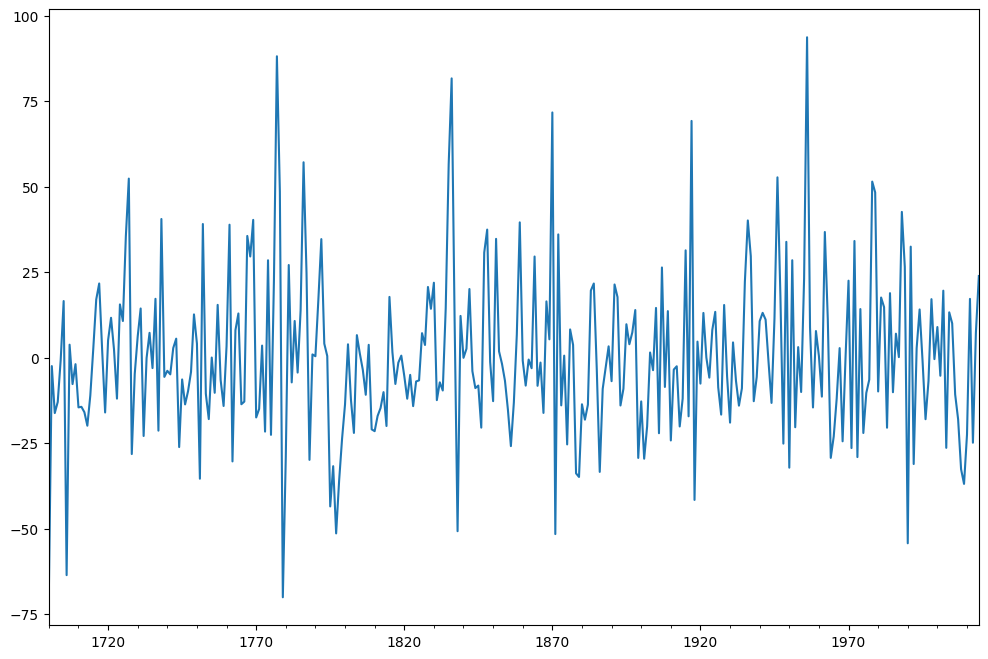

In [131]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod54.resid.plot(ax=ax)

In [132]:
resid = arma_mod54.resid
stats.normaltest(resid)

NormaltestResult(statistic=np.float64(31.18654699463549), pvalue=np.float64(1.690158233159604e-07))

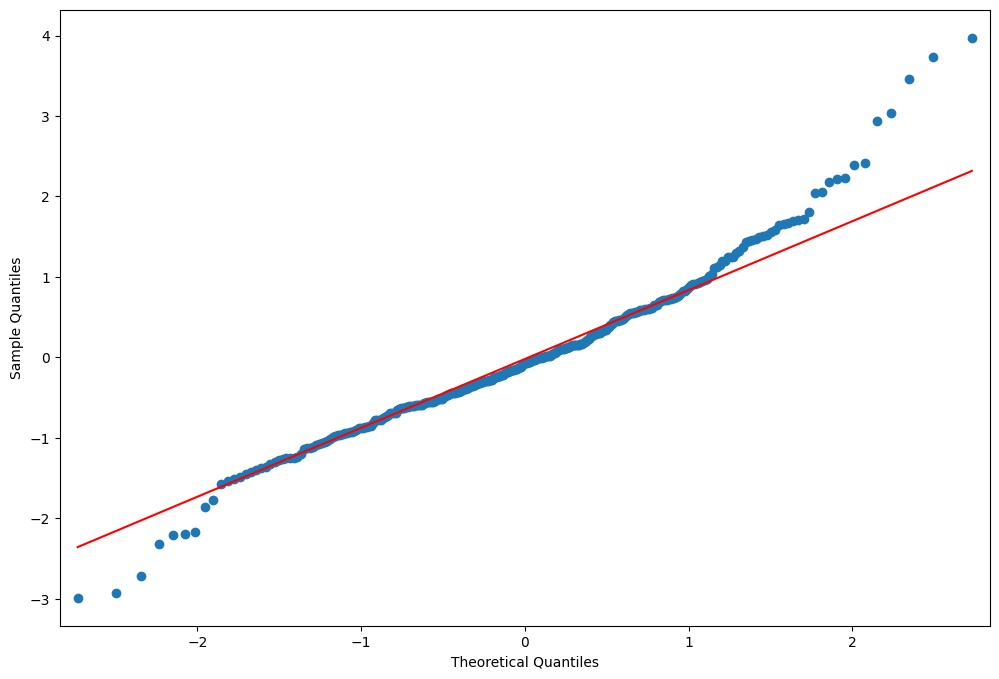

In [133]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

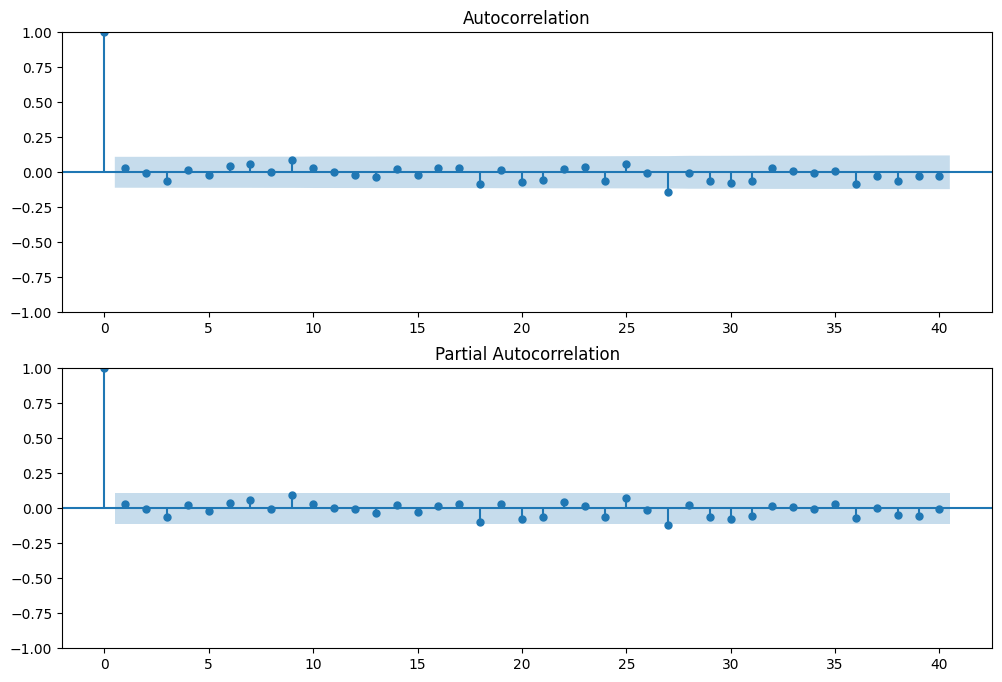

In [134]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [135]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
##
## AutoCorrelation, Q-value, P-value
##
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

           AC          Q  Prob(>Q)
lag                               
1    0.029231   0.271732  0.602172
2   -0.001915   0.272902  0.872449
3   -0.063320   1.556119  0.669380
4    0.019150   1.673863  0.795460
5   -0.017171   1.768839  0.880116
6    0.041274   2.319352  0.888112
7    0.057787   3.401971  0.845497
8    0.003803   3.406676  0.906311
9    0.085162   5.773339  0.762372
10   0.027702   6.024575  0.813194
11   0.003681   6.029025  0.871421
12  -0.016682   6.120734  0.909874
13  -0.031540   6.449651  0.928248
14   0.023813   6.637773  0.947775
15  -0.016022   6.723214  0.964880
16   0.032274   7.071067  0.971867
17   0.027234   7.319595  0.979020
18  -0.084904   9.743234  0.939965
19   0.019537   9.871999  0.956033
20  -0.069988  11.530058  0.931302
21  -0.052309  12.459400  0.926378
22   0.021371  12.615045  0.943345
23   0.040721  13.182088  0.947931
24  -0.064927  14.628633  0.931156


In [136]:
predict_sunspots = arma_mod54.predict("2010", "2024", dynamic=True)
predict_sunspots_onestep = arma_mod54.predict("1950", "2024", dynamic=False)
print(predict_sunspots)

2010-12-31     47.370537
2011-12-31     88.549114
2012-12-31    110.680501
2013-12-31    111.448725
2014-12-31     99.419471
2015-12-31     82.886163
2016-12-31     64.179222
2017-12-31     43.634693
2018-12-31     26.260240
2019-12-31     21.718773
2020-12-31     36.404836
2021-12-31     65.735097
2022-12-31     95.240211
2023-12-31    110.370909
2024-12-31    106.358296
Freq: YE-DEC, Name: predicted_mean, dtype: float64


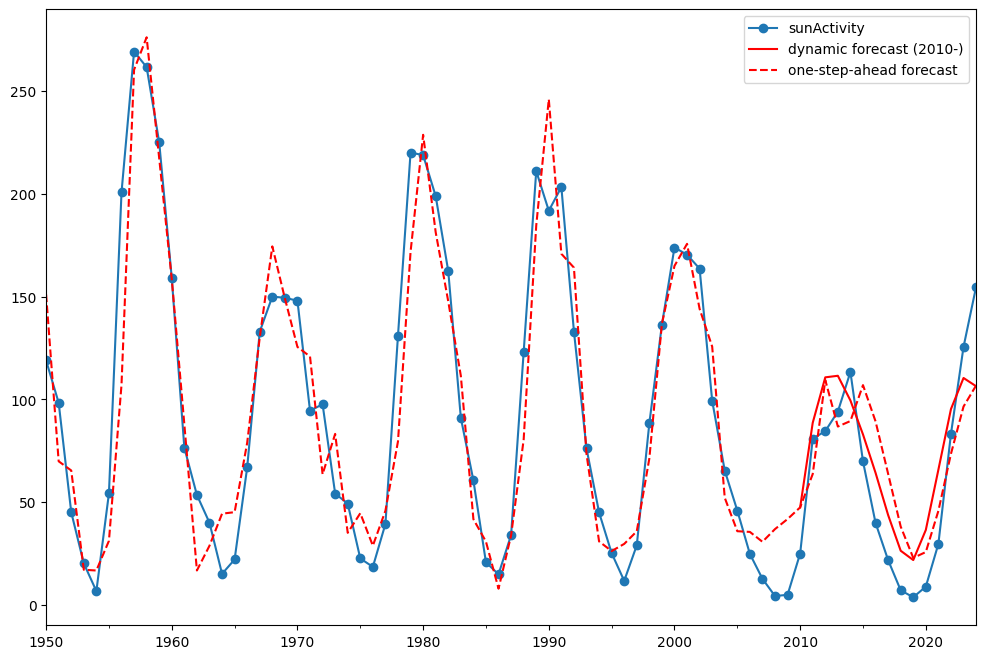

In [137]:
fig, ax = plt.subplots(figsize=(12, 8))
dtaFull.loc['1950':].plot(ax=ax,marker="o")
predict_sunspots.plot(ax=ax, style='r', label="dynamic forecast (2010-)")
predict_sunspots_onestep.plot(ax=ax, style='r--', label="one-step-ahead forecast")
plt.legend()

さて、AIC、BICのそれぞれで選択したARMA次数について、どちらを選べば良いだろうか？
通常、残差の自己相関の少ないほうを選択すればよい。今回の場合、どちらも残差の統計量の点では同等であるので、どちらを選んでも良い。

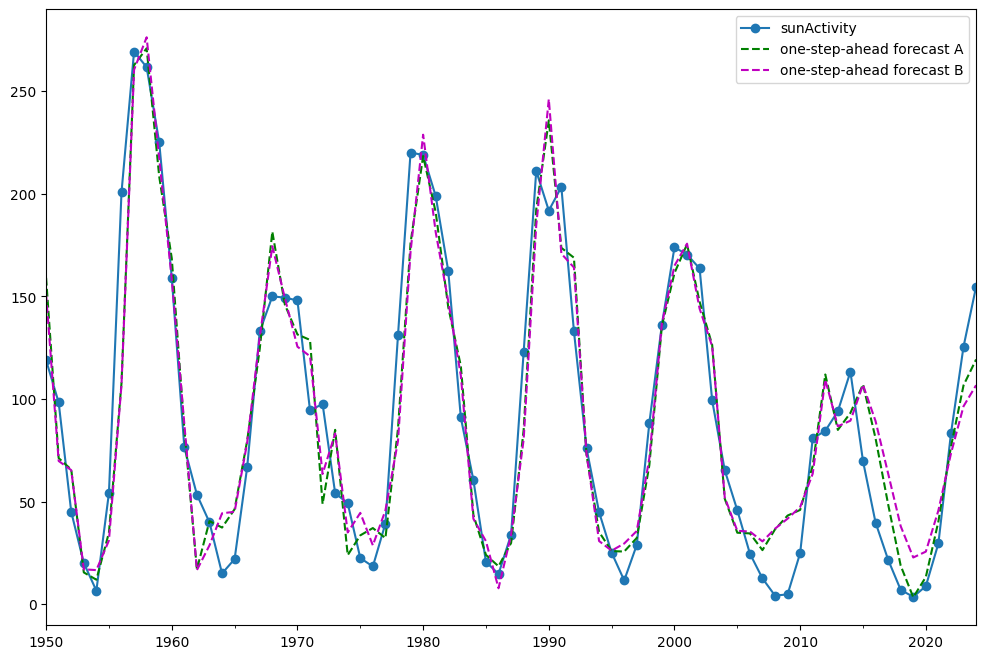

In [138]:
# 参考の比較(one-step-ahead forecast)
# predict_sunspots_modelA = arma_mod86.predict("2010", "2024", dynamic=True)
predict_sunspots_onestep_modelA = arma_mod86.predict("1950", "2024", dynamic=False)

# predict_sunspots_modelB = arma_mod54.predict("2010", "2024", dynamic=True)
predict_sunspots_onestep_modelB = arma_mod54.predict("1950", "2024", dynamic=False)

fig, ax = plt.subplots(figsize=(12, 8))
dtaFull.loc['1950':].plot(ax=ax,marker="o")
predict_sunspots_onestep_modelA.plot(ax=ax, style='g--', label="one-step-ahead forecast A")
predict_sunspots_onestep_modelB.plot(ax=ax, style='m--', label="one-step-ahead forecast B")
plt.legend()